# Perrin Freres Monthly Champagne Sales Forecast

### Objective
Create a time-series model to forecast the sales values for Perrin Freres Champagne for the next 12 months in the future

In [0]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# configurations
sns.set_style("whitegrid")

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import dataset
from google.colab import files
uploaded = files.upload()

Saving perrin-freres-monthly-champagne-.csv to perrin-freres-monthly-champagne-.csv


In [0]:
# load dataset
df = pd.read_csv("perrin-freres-monthly-champagne-.csv")

In [5]:
# preview dataset
df.head()

,Month,\tPerrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [0]:
# update feature names
df.columns = ['Month','Sales']

In [7]:
# preview dataset
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [8]:
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [0]:
# drop last 2 rows
df.drop(df.tail(2).index, inplace=True)

In [0]:
# update datetime
df['Month'] = pd.to_datetime(df['Month'])

# set index
df = df.set_index('Month')

# set frequency
df.index.freq = 'MS'

In [11]:
# preview dataset
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [12]:
df.tail()

,Sales
Month,
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0
1972-09-01,5877.0


# Visualize Dataset

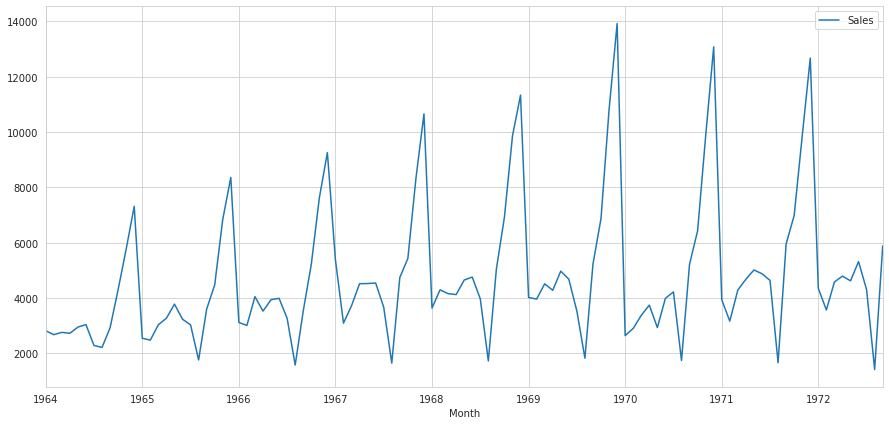

In [13]:
df.plot(figsize=(15,7))

- there is a updward trend in the dataset
- seasonality exists every 12 months

## Decompose Dataset

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

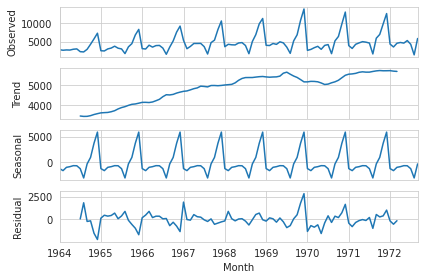

In [15]:
decompose = seasonal_decompose(df['Sales'], model='add')
decompose.plot();

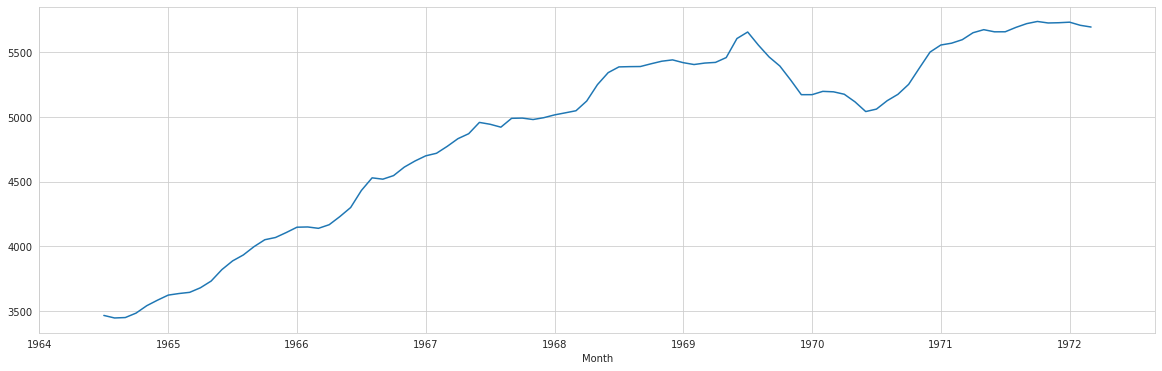

In [16]:
# plot trend
decompose.trend.plot(figsize=(20,6))

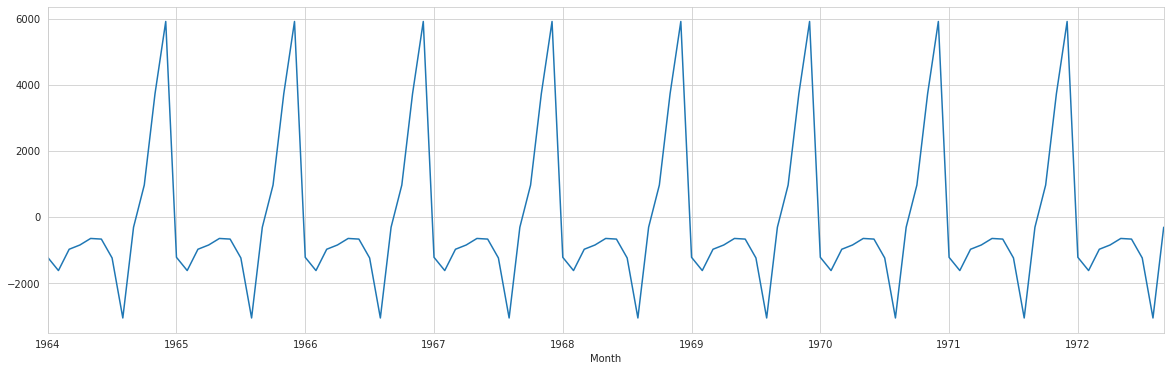

In [17]:
# plot seasonality
decompose.seasonal.plot(figsize=(20,6))

- seasonality is evident every year
- minimal trend is present as well

# Train-Test Split

In [18]:
len(df)

105

In [0]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [20]:
print(len(train))
print(len(test))

93
12


# Scale Dataset
- We need to normalize the data before feeding it to the neural network

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Modelling with RNN
## Time Series Generator
- This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

In [24]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [0]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [26]:
len(scaled_train)

93

In [27]:
len(generator)  # n_input = 2

91

In [0]:
# What does the first batch look like?
X,y = generator[0]

In [29]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.10062384 0.08903832]
Predict this y: 
 [[0.09576278]]


In [0]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# Create Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
model.fit_generator(generator, epochs=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





81/81 [==============================] - 11s 131ms/step - loss: 0.0532
Epoch 2/50
81/81 [==============================] - 2s 21ms/step - loss: 0.0428
Epoch 3/50
81/81 [==============================] - 2s 23ms/step - loss: 0.0439
Epoch 4/50
81/81 [==============================] - 2s 22ms/step - loss: 0.0459
Epoch 5/50
81/81 [==============================] - 2s 23ms/step - loss: 0.0391
Epoch 6/50
81/81 [==============================] - 2s 20ms/step - loss: 0.0367
Epoch 7/50
81/81 [==============================] - 2s 22ms/step - loss: 0.0468
Epoch 8/50
81/81 [==============================] - 2s 20ms/step - loss: 0.0420
Epoch 9/50
81/81 [==============================] - 2s 22ms/step - loss: 0.0314
Epoch 10/50
81/81 [==============================] - 2s 22ms/step - loss: 0.0192
Epoch 11/50
81/81 [==============================] - 2s 21ms/step - loss: 0.0155
Epoch 12/50
81

In [34]:
model.history.history.keys()

dict_keys(['loss'])

Text(0.5, 0, 'Epochs')

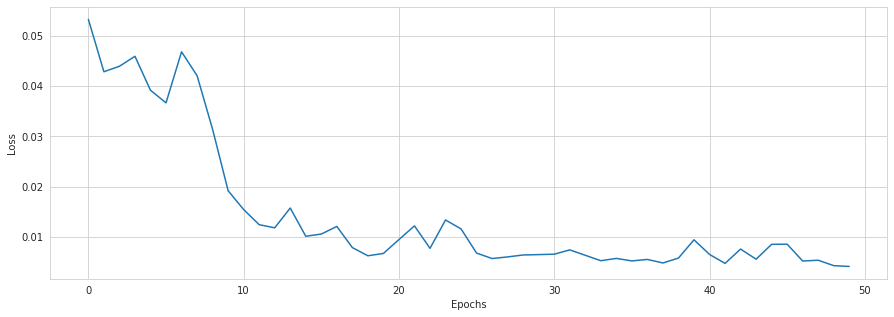

In [35]:
loss_per_epoch = model.history.history['loss']
plt.figure(figsize=(15,5))
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.ylabel("Loss")
plt.xlabel("Epochs")

# Model Evaluation
- Evaluate on test data

In [36]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.39301628],
       [0.66993438],
       [0.93194523],
       [0.19128251],
       [0.12873694],
       [0.2198007 ],
       [0.25139755],
       [0.27845743],
       [0.26743903],
       [0.2479138 ],
       [0.00696751],
       [0.35469497]])

In [0]:
first_eval_batch = first_eval_batch.reshape(1, n_input, n_features)

In [38]:
model.predict(first_eval_batch)

array([[0.45176384]], dtype=float32)

In [39]:
scaled_test[0]

array([0.43814308])

# Forecast
- on test dataset

In [0]:
test_predictions = []  # for holding predictions

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# RNN Timeseriesgenerator requires this shape format
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):  # forecasting only for the length of the test dataset
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [42]:
test_predictions

[array([0.45176384], dtype=float32),
 array([0.7237835], dtype=float32),
 array([0.95313257], dtype=float32),
 array([0.19944781], dtype=float32),
 array([0.13149087], dtype=float32),
 array([0.16595322], dtype=float32),
 array([0.19250858], dtype=float32),
 array([0.22743282], dtype=float32),
 array([0.23828033], dtype=float32),
 array([0.22756779], dtype=float32),
 array([0.06342827], dtype=float32),
 array([0.37729168], dtype=float32)]

In [43]:
scaled_test

array([[ 0.43814308],
       [ 0.67066353],
       [ 0.89905209],
       [ 0.22482379],
       [ 0.161306  ],
       [ 0.24337681],
       [ 0.26047152],
       [ 0.24669853],
       [ 0.30292473],
       [ 0.22077291],
       [-0.01296281],
       [ 0.34869967]])

# Inverse Transformations & Compare

In [44]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 7149.12105897],
       [10506.65965462],
       [13337.51530892],
       [ 4034.78432685],
       [ 3195.99182458],
       [ 3621.36058134],
       [ 3949.13338196],
       [ 4380.20326295],
       [ 4514.0940654 ],
       [ 4381.8692559 ],
       [ 2355.89510991],
       [ 6229.91119862]])

In [45]:
test

,Sales
Month,
1971-10-01,6981.0
1971-11-01,9851.0
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0


In [46]:
test['Forecast'] = true_predictions
test

,Sales,Forecast
Month,,
1971-10-01,6981.0,7149.121059
1971-11-01,9851.0,10506.659655
1971-12-01,12670.0,13337.515309
1972-01-01,4348.0,4034.784327
1972-02-01,3564.0,3195.991825
1972-03-01,4577.0,3621.360581
1972-04-01,4788.0,3949.133382
1972-05-01,4618.0,4380.203263
1972-06-01,5312.0,4514.094065


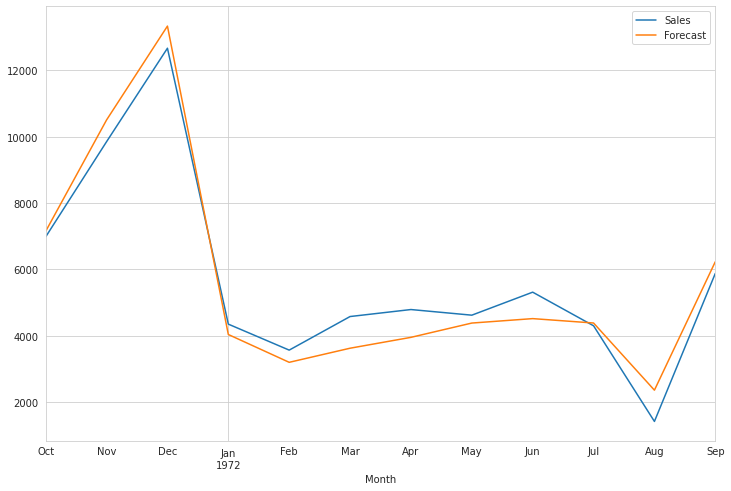

In [47]:
# visualize forecast
test.plot(figsize=(12,8))

# Forecast
- For 12 months in the future

## Train the model on entire dataset

### Scale dataset

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [0]:
scaler.fit(df)
scaled_data = scaler.transform(df)

### Time Series Generator

In [0]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
# define generator
n_input = 12  # define number of batches to predict the consecutive point
n_features = 1  # generally will be 1 for time series forecast
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

In [52]:
generator[0]

(array([[[0.11213309],
         [0.10069583],
         [0.10733424],
         [0.10461489],
         [0.12261057],
         [0.12980885],
         [0.06950332],
         [0.06390466],
         [0.12069103],
         [0.23098456],
         [0.34799648],
         [0.47180677]]]), array([[0.09021835]]))

In [0]:
# tuple unpacking for the generator object
X,y = generator[0]

In [54]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11213309 0.10069583 0.10733424 0.10461489 0.12261057 0.12980885
 0.06950332 0.06390466 0.12069103 0.23098456 0.34799648 0.47180677]
Predict this y: 
 [[0.09021835]]


### Create Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [56]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [57]:
# fit model
model.fit_generator(generator, epochs=50)

Epoch 1/50
93/93 [==============================] - 3s 27ms/step - loss: 0.0630
Epoch 2/50
93/93 [==============================] - 2s 22ms/step - loss: 0.0431
Epoch 3/50
93/93 [==============================] - 2s 21ms/step - loss: 0.0390
Epoch 4/50
93/93 [==============================] - 2s 22ms/step - loss: 0.0285
Epoch 5/50
93/93 [==============================] - 2s 24ms/step - loss: 0.0323
Epoch 6/50
93/93 [==============================] - 2s 20ms/step - loss: 0.0524
Epoch 7/50
93/93 [==============================] - 2s 22ms/step - loss: 0.0308
Epoch 8/50
93/93 [==============================] - 2s 21ms/step - loss: 0.0292
Epoch 9/50
93/93 [==============================] - 2s 23ms/step - loss: 0.0264
Epoch 10/50
93/93 [==============================] - 2s 25ms/step - loss: 0.0174
Epoch 11/50
93/93 [==============================] - 2s 23ms/step - loss: 0.0166
Epoch 12/50
93/93 [==============================] - 2s 21ms/step - loss: 0.0144
Epoch 13/50
93/93 [==================

In [58]:
model.history.history.keys()

dict_keys(['loss'])

Text(0, 0.5, 'Loss')

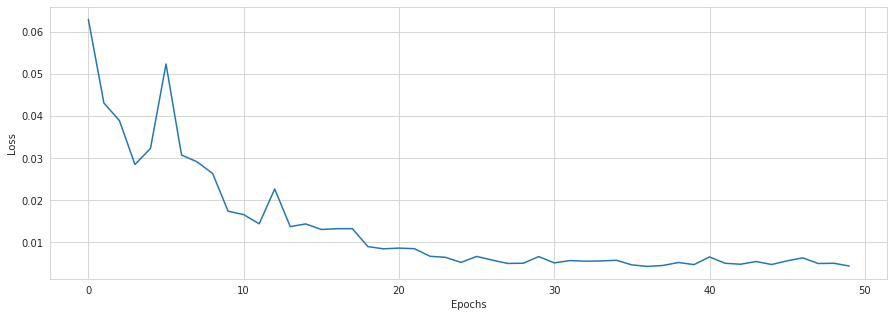

In [59]:
loss_per_epoch = model.history.history['loss']
plt.figure(figsize=(15,5))
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Forecast into future

In [0]:
predictions = []  # to store forecast values

first_eval_batch = scaled_train[-n_input:] # last n_input points from the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features))  # RNN Timeseriesgenerator requires this shape format

for i in range(len(df)+12):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transformations

In [0]:
forecast = scaler.inverse_transform(predictions)

In [0]:
forecast_df = pd.DataFrame(forecast)

In [0]:
forecast_df.columns = ['sales_forecast']

In [64]:
forecast_df

,sales_forecast
0,7.309749e+03
1,1.166248e+04
2,1.536577e+04
3,4.274440e+03
4,3.398236e+03
...,...
112,5.407847e+13
113,3.830581e+13
114,1.202639e+14
115,9.046984e+13


In [65]:
len(df)

105

In [71]:
forecast_df.tail()

,sales_forecast
112,5.407847e+13
113,3.830581e+13
114,1.202639e+14
115,9.046984e+13
116,4.116991e+14


In [0]:
# df_new = pd.concat(df, forecast_df)
# df_new.tail(15)

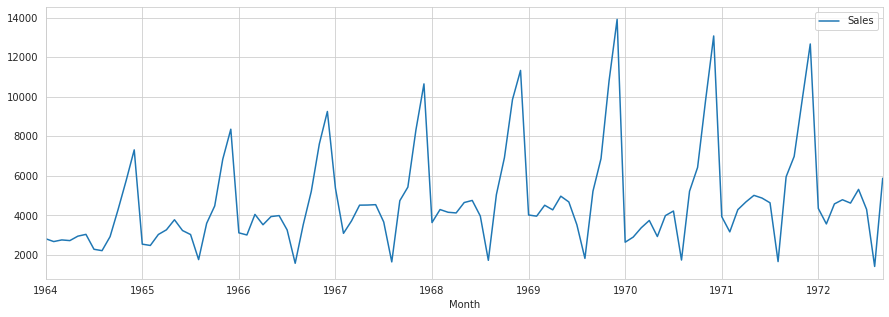

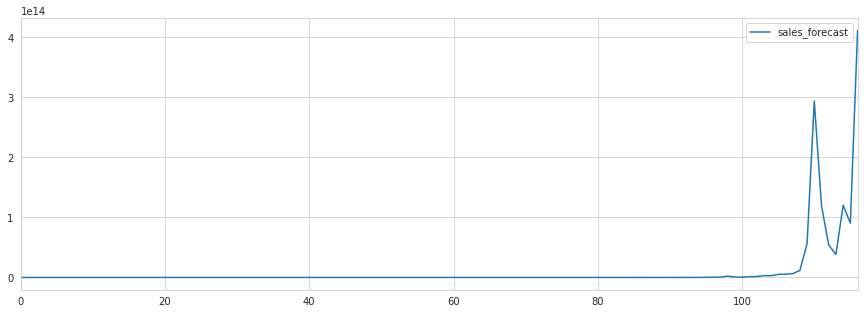

In [73]:
df['Sales'].plot(figsize=(15,5), legend=True)
# predictions.plot(legend=True)
forecast_df.plot(figsize=(15,5), legend=True)